In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
import warnings
import numpy as np
import os
from scipy.stats import shapiro 
warnings.filterwarnings('ignore')

# Procesamiento de los datos

In [2]:
#Leer los dataframes
Meteo=pd.read_csv("UH_2023/DATOS_METEO.TXT", sep="|")
Eto=pd.read_csv("UH_2023/DATOS_ETO.TXT", sep="|")
df=pd.read_csv("UH_2023/UH_2023_TRAIN.txt", sep="|")

In [3]:
#Cambiar el formato de la fecha y extraer el año
Meteo["validTimeUtc"]=pd.to_datetime(Meteo["validTimeUtc"])
Meteo["Year"]=Meteo["validTimeUtc"].dt.strftime('%Y')
Meteo["Month"]=Meteo["validTimeUtc"].dt.strftime('%m')
Eto["date"]=pd.to_datetime(Eto["date"], format='%Y%m%d')
Eto["Year"]=Eto["date"].dt.strftime('%Y')
Eto["Month"]=Eto["date"].dt.strftime('%m')
df["Year"]=2000+df["CAMPAÑA"]
#Eliminamos las fechas porque no nos interesan
df.drop("CAMPAÑA", axis=1, inplace=True)
Eto.drop("date", axis=1, inplace=True)
Meteo.drop("validTimeUtc", axis=1, inplace=True)
#Cambiamos el formato de la altitud
df["ALTITUD"]=df["ALTITUD"].str.slice(0, 3)
#Anotamos cada mes por la etapa del ciclo de producción de uva en el que estamos
etapas_cultivo=['Parada', 'Brotacion', 'Foliacion', 'Envero', 'Maduracion']
etapas = {'01': 'Parada', '02' : 'Parada', '03' : 'Brotacion', '04' : 'Foliacion', '05' : 'Foliacion', 
          '06' : 'Envero', '07' : 'Envero', '08' : 'Envero', '09' : 'Maduracion', '10' : 'Maduracion', 
          '11' : 'Parada', '12' : 'Parada'}
Eto=Eto.replace({"Month": etapas})
Meteo=Meteo.replace({"Month": etapas})

Con esta función pretendemos extraer y agrupar los datos que serán de interés para la predicción, para realizar el entrenamiento, nos quedaremos con **la información de las parcelas y los datos meteorológicos, agrupados por año y por etapa de la producción de la uva ('Parada', 'Brotacion', 'Foliacion', 'Envero' y 'Maduracion')**.

In [4]:
def Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo):
    df_merged=df[df["Year"]==(last_year)].set_index(["ID_FINCA","VARIEDAD"])[['ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'MODO',
       'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION', "Year"]]
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_eto=Eto[Eto["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['min','max','sum','mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Eto[(Eto["Year"]==(str(last_year))) & (Eto["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['min','max','sum','mean'])
        df_eto=df_eto.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.reset_index().merge(df_eto, on="ID_ESTACION")
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_meteo=Meteo[Meteo["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['min','max','sum','mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Meteo[(Meteo["Year"]==(str(last_year))) & (Meteo["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['min','max','sum','mean'])
        df_meteo=df_meteo.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.merge(df_meteo, on="ID_ESTACION")
    return(df_merged)
    

In [5]:
#Utilizamos la función generada para crear el dataframe que usaremos en entrenamiento, centrado en el año 2021
X_2020=Agrupate_By_Year(last_year=2020, df=df, Eto=Eto, Meteo=Meteo)
X_2019=Agrupate_By_Year(last_year=2019, df=df, Eto=Eto, Meteo=Meteo)
X_2018=Agrupate_By_Year(last_year=2018, df=df, Eto=Eto, Meteo=Meteo)
X_2017=Agrupate_By_Year(last_year=2017, df=df, Eto=Eto, Meteo=Meteo)
X_2016=Agrupate_By_Year(last_year=2016, df=df, Eto=Eto, Meteo=Meteo)
X_train=pd.concat([X_2020,X_2019,X_2018,X_2017,X_2016])
X_test=Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo)

In [6]:
variables=X_train.columns
cat_variables=['ID_FINCA','VARIEDAD','ID_ZONA','ID_ESTACION','MODO','TIPO','COLOR', "ALTITUD"]
variables=variables.drop(cat_variables).to_list()
print(f' dataset train has {X_train.shape}')
print(f' dataset test has {X_test.shape}')

 dataset train has (5218, 7307)
 dataset test has (1044, 7307)


# Visualización de las variables de estudio

In [7]:
#Generamos una variable PRODUCCION/M para ver la rentabilidad de los terrenos
X_train["PRODUCCION/M"]=X_train["PRODUCCION"]/X_train["SUPERFICIE"]
X_train["PRODUCCION/M"].replace(np.inf,np.nan, inplace=True)

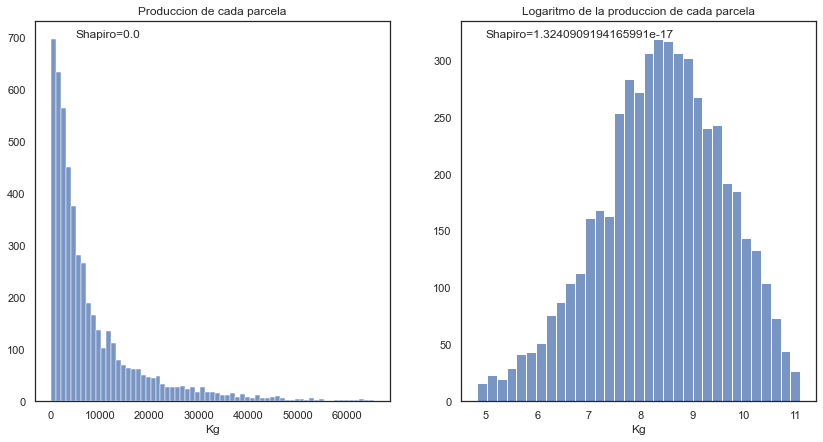

In [9]:
# Análisis de la distribución de las variable PRODUCCION
f = plt.figure(figsize=(14,7)) #Generamos la figura
bar_produccion = plt.subplot(1, 2, 1)
X_train_cut=X_train[X_train["PRODUCCION"]>X_train["PRODUCCION"].quantile(q=0.01)]
X_train_cut=X_train_cut[X_train_cut["PRODUCCION"]<X_train["PRODUCCION"].quantile(q=0.99)]
#Histograma de la producción de cada parcela
sns.histplot(data=X_train_cut, x="PRODUCCION")
plt.title("Produccion de cada parcela")
plt.ylabel(None)
plt.xlabel("Kg")
shap=str(shapiro(X_train["PRODUCCION"]).pvalue)
plt.text(5000, 700, str('Shapiro='+shap))
bar_horas = plt.subplot(1, 2, 2)

produccion_log=np.log1p(X_train_cut["PRODUCCION"])
sns.histplot(x=produccion_log)
plt.title("Logaritmo de la produccion de cada parcela")
plt.ylabel(None)
plt.xlabel("Kg")
shap=str(shapiro(produccion_log).pvalue)
plt.text(5, 320, str('Shapiro='+shap))
plt.savefig("Distribución.jpeg", dpi=600, bbox_inches='tight')

Podemos ver que la distribución de la variable producción dista enormemente de la normalidad, eso puede afectar a la predicción de los valores enormemente, por ello decidimos utilizar una transformación log1p en el desarrollo de los modelos pudiendo obtener así una mejoría en el desempeño de los modelos. Eliminando además las parcelas que tienen una producción menor que el quantil 1%, podemos observar una tremenda mejoría en la distribución. Pese a que todavía no se puede asumir la normalidad.

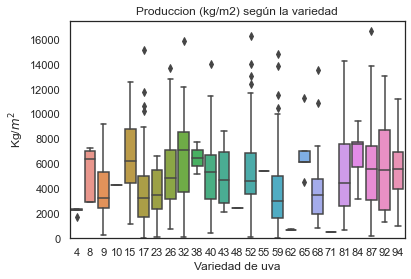

In [10]:
#Rentabilidad de las parcelas (anotada como producción por m^2) según la variedad
sns.boxplot(data=X_train, x="VARIEDAD", y="PRODUCCION/M")
plt.xlabel("Variedad de uva")
plt.ylabel("Kg/$m^2$")
plt.ylim(top=17500, bottom=0)
plt.title("Produccion (kg/m2) según la variedad")
plt.savefig("Analítica1.jpeg", dpi=600, bbox_inches='tight')

Parece que la variedad de uva cultivada, no parece tener un efecto en el rendimiento de los cultivos (calculados como la rentabilidad en kg/m2)

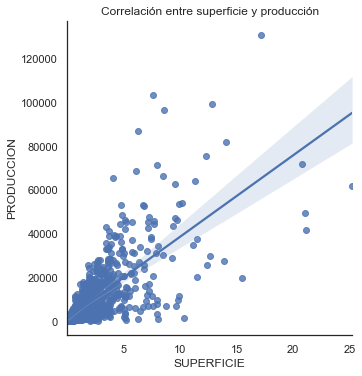

In [11]:
#Correlación entre superficie y producción
sns.lmplot(data=X_train[X_train["SUPERFICIE"]!=0], x="SUPERFICIE", y="PRODUCCION", fit_reg=True)
plt.title("Correlación entre superficie y producción")
plt.savefig("Analítica.jpeg", dpi=600, bbox_inches='tight')

 Se puede observar una clara correlación entre la superficie de la parcela y su producción. Siendo esta variable relevante en el desarrollo de los modelos predictivos.

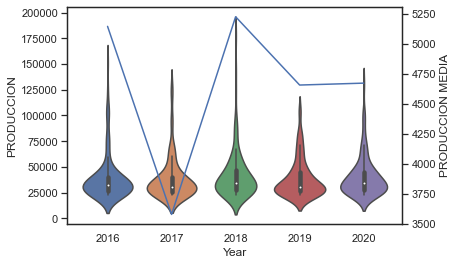

In [73]:
#Producción de las parcelas a lo largo de los años
sns.violinplot(data=X_train[X_train["PRODUCCION"]>X_train["PRODUCCION"].quantile(q=0.9)], x="Year", y="PRODUCCION")
plt.twinx()
Galaxy = plt.plot([0, 1, 2, 3, 4], X_train.groupby("Year").median()["PRODUCCION"])
plt.ylabel('PRODUCCION MEDIA')
plt.show()

También podemos observar que algunos años la producción media a aumentado o descendido notablemente pero que la distribución de los valores de producción parece mantenerse constante a lo largo de los años.

In [12]:
if not os.path.isfile("correlation.csv"):
    correlation=X_train.corr().loc[['PRODUCCION', 'PRODUCCION/M'],:]
    correlation.T.to_csv("correlation.csv")
# Si se habían generado anteriormente, y el archivo está disponible, lo lee. 
else:
    correlation=pd.read_csv("correlation.csv", index_col=0)

Text(0.5, 12.5, 'Producción (kg)')

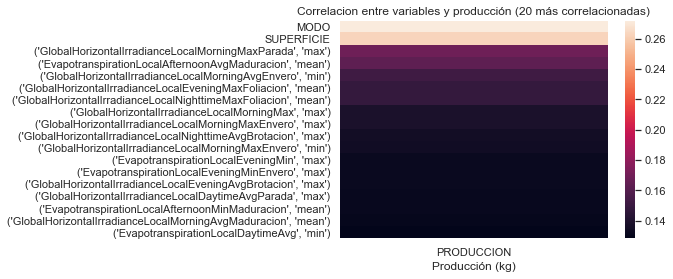

In [13]:
#Mapa de calor de correlación con la producción de cada parcela
sns.heatmap(pd.DataFrame(correlation["PRODUCCION"].nlargest(20).drop(["PRODUCCION/M","PRODUCCION"])))
plt.title("Correlacion entre variables y producción (20 más correlacionadas)")
plt.xlabel("Producción (kg)")

Text(0.5, 12.5, 'Producción (kg)')

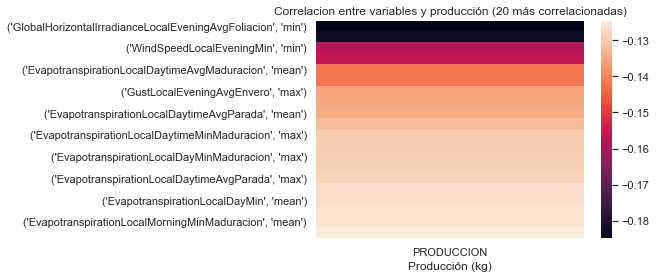

In [14]:
#Mapa de calor de correlación con la producción de cada parcela
sns.heatmap(pd.DataFrame(correlation["PRODUCCION"].nsmallest(20)))
plt.title("Correlacion entre variables y producción (20 más correlacionadas)")
plt.xlabel("Producción (kg)")

    -Parece ser que las variables mayor correlación positiva con la producción son la máxima irradiación horizontal local por la mañana en la época de parada, la media de evotranspiración durante la tarde en época de maduración y la mínima irradiación horizontal local por la mañana en envero. Pudiendo ser estas claves climáticas de una buena producción de uva.
    -Por otro lado las variables con mayor correlación negativa con la producción son la mínima irradiación horizontal local por la tarde en foliación, el mínimo de velocidad del viento a lo largo del año y la media de evotranspiración durante la maduración.

#### Aunque estos podrían indicar ciertas tendencias sobre los factores claves en producción, ninguna de las variables presenta una correlación lineal elevada y eso se tendrá que tener en cuenta en el desarrollo de los modelos.

# Generación del modelo de predicción de superficie

Se probaron modelos de KNNRegressor y RandomForest, siendo estos últimos los que se terminaron utilizando en el modelo final. El modelo de RandomForest fue ajustado los parámetros haciendo uso de GridSearchCV, haciendo uso de una plantilla de diferentes parámetros a testar.

## Ajuste de los parámetros de los modelos
Aquí se muestra un ejemplo del proceso utilizado para la optimización de los modelos de RandomForest usandos en predicción de la superficie y producción

In [214]:
#Pipeline para el procesamiento de variables categóricas
categoricas= Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value="None")), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Pipeline para el procesamiento de variables numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('scaler', StandardScaler())])

hack_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variables),
        ('cat', categoricas, cat_variables)])

In [ ]:
parameters={'clas__bootstrap': [True, False], 'clas__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'clas__max_features': ['auto', 'sqrt'], 'clas__min_samples_leaf': [1, 2, 4], 'clas__min_samples_split': [2, 5, 10], 
            'clas__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RandomForestRegressor())])

GS = GridSearchCV(hack_pipe_RF, param_grid=parameters, cv=5, verbose=10, scoring='neg_root_mean_squared_error')
GS.fit(X_train, y_train)
